In [1]:
import sys
sys.path.append('..')
from osp import *

In [67]:
WORDSETS = ['top', 'content', 'non_content']

def get_wordsets(wordsets=WORDSETS, n_words=100):
    wordsets_words = {}
    for wordset in wordsets:
        if wordset == 'non_content':
            wordsets_words[wordset] = get_non_content_words()[:n_words]
        else:
            wordsets_words[wordset] = get_top_mdw_words(n=n_words, wordset=wordset)
    return wordsets_words

In [70]:
wordsets_words=get_wordsets(n_words=1000)
# wordsets_words

In [71]:
len(wordsets_words['non_content'])

780

In [ ]:
all_data = {}
for wordset, words in wordsets_words.items():
    all_data[wordset] = get_counts_wordset(words)



  5%|▌         | 3139/58126 [00:20<06:07, 149.71it/s]

In [ ]:
def iter_pairwise_samples(data, colname='period',data_meta=None,balance=True, sample_size=None):
    data_meta = get_corpus_metadata() if data_meta is None else data_meta
    min_grp_size = min(data_meta.groupby(colname).size())
    data_meta = data_meta.groupby(colname).sample(n=min_grp_size)
    data_smpl = data.sample(frac=1)

    coltypes = data_meta[colname].unique()
    for coltype1 in coltypes:
        for coltype2 in coltypes:
            if coltype1 >= coltype2:
                continue
            df_meta_yes = data_meta.query(f'{colname}==@coltype1')
            df_meta_no = data_meta.query(f'{colname}==@coltype2')
                
            data_smpl_yes = data_smpl.loc[[i for i in df_meta_yes.index if i in data.index]].assign(_target=coltype1)
            data_smpl_no = data_smpl.loc[[i for i in df_meta_no.index if i in data.index]].assign(_target=coltype2)

            if balance:
                if sample_size is None:
                    minsize = min(data_smpl_yes.shape[0],data_smpl_no.shape[0])
                    data_smpl_yes = data_smpl_yes.sample(n=minsize)
                    data_smpl_no = data_smpl_no.sample(n=minsize)
                else:
                    data_smpl_yes = data_smpl_yes.sample(n=sample_size, replace=True)
                    data_smpl_no = data_smpl_no.sample(n=sample_size, replace=True)
            yield (coltype1, coltype2), pd.concat([data_smpl_yes,data_smpl_no]).sample(frac=1)


In [ ]:
def classify_pairwise_samples(data, colname='period',data_meta=None,balance=True, sample_size=None, verbose=True):
    iterr = iter_pairwise_samples(data,colname=colname,data_meta=data_meta,balance=balance, sample_size=sample_size)

    out_preds = []
    out_feats = []
    for g,gfx in tqdm(list(iterr),desc=f'classifying pairwise samples for {colname}'):
        meta = {'test_group': ' vs. '.join(g) if isinstance(g,(list,tuple)) else g, 'test_group_type': colname}
        gdf_preds, gdf_feats = classify_data(gfx)
        out_preds.append(gdf_preds.assign(**meta))
        out_feats.append(gdf_feats.assign(**meta))
    odf_preds, odf_feats = pd.concat(out_preds), pd.concat(out_feats)
    odf_preds.sort_values('accuracy',ascending=False,inplace=True)
    odf_feats.sort_values('weight',ascending=False,inplace=True)
    return odf_preds, odf_feats


In [ ]:
df_meta = get_corpus_metadata(periodize_by=30).query('year>=1900 and year<2020')
df_meta_lit = df_meta.query('discipline == "Literature"')
df_meta_phil = df_meta.query('discipline == "Philosophy"')

In [ ]:
def classify_all_data(wordset2data, classify_by=['discipline'], data_meta=None, sample_size=2500, verbose=False):

    all_df_preds = []
    all_df_feats = []

    # iterr = tqdm(wordset2data.items(),desc='classifying by wordsets')
    for wordset,data in wordset2data.items():
        print(wordset)
        for classify_by_x in classify_by:
            # iterr.set_description(f'classifying {wordset} {classify_by_x}')

            df_preds, df_feats = classify_pairwise_samples(data, classify_by_x, data_meta=data_meta, sample_size=sample_size, verbose=verbose)
            all_df_preds.append(df_preds.assign(wordset=wordset, classify_by=classify_by_x))
            all_df_feats.append(df_feats.assign(wordset=wordset, classify_by=classify_by_x))

    all_df_preds = pd.concat(all_df_preds) if all_df_preds else pd.DataFrame()
    all_df_feats = pd.concat(all_df_feats) if all_df_feats else pd.DataFrame()

    return all_df_preds, all_df_feats

In [ ]:
all_df_preds, all_df_feats = classify_all_data(
    all_data, 
    classify_by=['decade_discipline'], 
    data_meta=df_meta, 
    sample_size=1000,
    verbose=False
)
all_df_preds.head(25)

[wordset: non_content] classifying pairwise samples for decade_discipline: 100%|██████████| 276/276 [01:26<00:00,  3.19it/s]
[wordset: non_content] classifying pairwise samples for decade_discipline: 100%|██████████| 276/276 [01:18<00:00,  3.52it/s]
[wordset: non_content] classifying pairwise samples for decade_discipline: 100%|██████████| 276/276 [01:30<00:00,  3.04it/s]


,true_label,pred_label,test_label,confidence,correct,accuracy,test_group,test_group_type,wordset,classify_by
id,,,,,,,,,,
phil/10.2307/40040768,2000 Philosophy,2000 Philosophy,1930 Literature / 2000 Philosophy,0.999734,True,0.995,1930 Literature vs. 2000 Philosophy,decade_discipline,top,decade_discipline
lit/457801,1930 Literature,1930 Literature,1930 Literature / 2000 Philosophy,0.998123,True,0.995,1930 Literature vs. 2000 Philosophy,decade_discipline,top,decade_discipline
lit/3715641,1930 Literature,1930 Literature,1930 Literature / 2000 Philosophy,0.974723,True,0.995,1930 Literature vs. 2000 Philosophy,decade_discipline,top,decade_discipline
lit/509968,1930 Literature,1930 Literature,1930 Literature / 2000 Philosophy,1.000000,True,0.995,1930 Literature vs. 2000 Philosophy,decade_discipline,top,decade_discipline
lit/3715456,1930 Literature,1930 Literature,1930 Literature / 2000 Philosophy,0.989524,True,0.995,1930 Literature vs. 2000 Philosophy,decade_discipline,top,decade_discipline
lit/508633,1930 Literature,1930 Literature,1930 Literature / 2000 Philosophy,0.999838,True,0.995,1930 Literature vs. 2000 Philosophy,decade_discipline,top,decade_discipline
lit/457953,1930 Literature,1930 Literature,1930 Literature / 2000 Philosophy,0.995086,True,0.995,1930 Literature vs. 2000 Philosophy,decade_discipline,top,decade_discipline
lit/508457,1930 Literature,1930 Literature,1930 Literature / 2000 Philosophy,0.999934,True,0.995,1930 Literature vs. 2000 Philosophy,decade_discipline,top,decade_discipline
lit/507818,1930 Literature,1930 Literature,1930 Literature / 2000 Philosophy,0.994163,True,0.995,1930 Literature vs. 2000 Philosophy,decade_discipline,top,decade_discipline


In [ ]:
df_preds_sum = all_df_preds.groupby(['wordset','test_label']).mean(numeric_only=True).sort_values('accuracy',ascending=False).reset_index()
grps = [x.split(' / ') for x in df_preds_sum['test_label']]
df_preds_sum['group1'], df_preds_sum['group2'] = zip(*grps)
df_preds_sum['period1'], df_preds_sum['discipline1'] = zip(*[x.split(' ') for x in df_preds_sum['group1']])
df_preds_sum['period2'], df_preds_sum['discipline2'] = zip(*[x.split(' ') for x in df_preds_sum['group2']])
df_preds_sum['confusion'] = 1 - df_preds_sum['accuracy']

def categorize_row(row):
    out = ''
    if row.period1 == row.period2:
        out += 'within periods'
    else:
        out += 'across periods'
    if row.discipline1 == row.discipline2:
        out += ' and within disciplines'
    else:
        out += ' and across disciplines'
    return out
df_preds_sum['categorization'] = df_preds_sum.apply(categorize_row, axis=1)
df_preds_sum[['period1','period2','discipline1','discipline2','categorization']]
df_preds_sum.categorization.value_counts()

categorization
across periods and across disciplines    396
across periods and within disciplines    396
within periods and across disciplines     36
Name: count, dtype: int64

In [ ]:
df_preds_sum.groupby(['categorization','wordset']).mean(numeric_only=True).sort_values('accuracy',ascending=False).round(2)

confidence  correct  \
categorization                        wordset                            
across periods and across disciplines top                0.97     0.97   
                                      content            0.97     0.97   
within periods and across disciplines top                0.96     0.96   
                                      content            0.96     0.96   
across periods and across disciplines non_content        0.92     0.94   
within periods and across disciplines non_content        0.91     0.93   
across periods and within disciplines content            0.83     0.81   
                                      non_content        0.78     0.81   
                                      top                0.82     0.80   

                                                   accuracy  confusion  
categorization                        wordset                           
across periods and across disciplines top              0.97       0.03  
                                      content          0.97       0.03  
within periods and across disciplines top              0.96       0.04  
                                      content          0.96       0.04  
across periods and across disciplines non_content      0.94       0.06  
within periods and across disciplines non_content      0.93       0.07  
across periods and within disciplines content          0.81       0.19  
                                      non_content      0.81       0.19  
                                      top              0.80       0.20

In [ ]:
df_preds_sum

,wordset,test_label,confidence,correct,accuracy,group1,group2,period1,discipline1,period2,discipline2,confusion,categorization
0,content,1900 Literature / 2010 Philosophy,0.991918,0.9980,0.9980,1900 Literature,2010 Philosophy,1900,Literature,2010,Philosophy,0.0020,across periods and across disciplines
1,content,1900 Philosophy / 2010 Literature,0.988591,0.9955,0.9955,1900 Philosophy,2010 Literature,1900,Philosophy,2010,Literature,0.0045,across periods and across disciplines
2,top,1930 Literature / 2000 Philosophy,0.992409,0.9950,0.9950,1930 Literature,2000 Philosophy,1930,Literature,2000,Philosophy,0.0050,across periods and across disciplines
3,content,1900 Literature / 2000 Philosophy,0.990843,0.9950,0.9950,1900 Literature,2000 Philosophy,1900,Literature,2000,Philosophy,0.0050,across periods and across disciplines
4,top,1950 Literature / 2000 Philosophy,0.988585,0.9940,0.9940,1950 Literature,2000 Philosophy,1950,Literature,2000,Philosophy,0.0060,across periods and across disciplines
...,...,...,...,...,...,...,...,...,...,...,...,...,...
823,top,1940 Literature / 1950 Literature,0.646501,0.5920,0.5920,1940 Literature,1950 Literature,1940,Literature,1950,Literature,0.4080,across periods and within disciplines
824,top,1900 Philosophy / 1910 Philosophy,0.653164,0.5915,0.5915,1900 Philosophy,1910 Philosophy,1900,Philosophy,1910,Philosophy,0.4085,across periods and within disciplines
825,top,1980 Philosophy / 1990 Philosophy,0.644306,0.5900,0.5900,1980 Philosophy,1990 Philosophy,1980,Philosophy,1990,Philosophy,0.4100,across periods and within disciplines
826,non_content,1950 Literature / 1960 Literature,0.621771,0.5885,0.5885,1950 Literature,1960 Literature,1950,Literature,1960,Literature,0.4115,across periods and within disciplines


In [ ]:
df_preds_sum['correct_fpk'] = (df_preds_sum['accuracy'] * 100).apply(int)

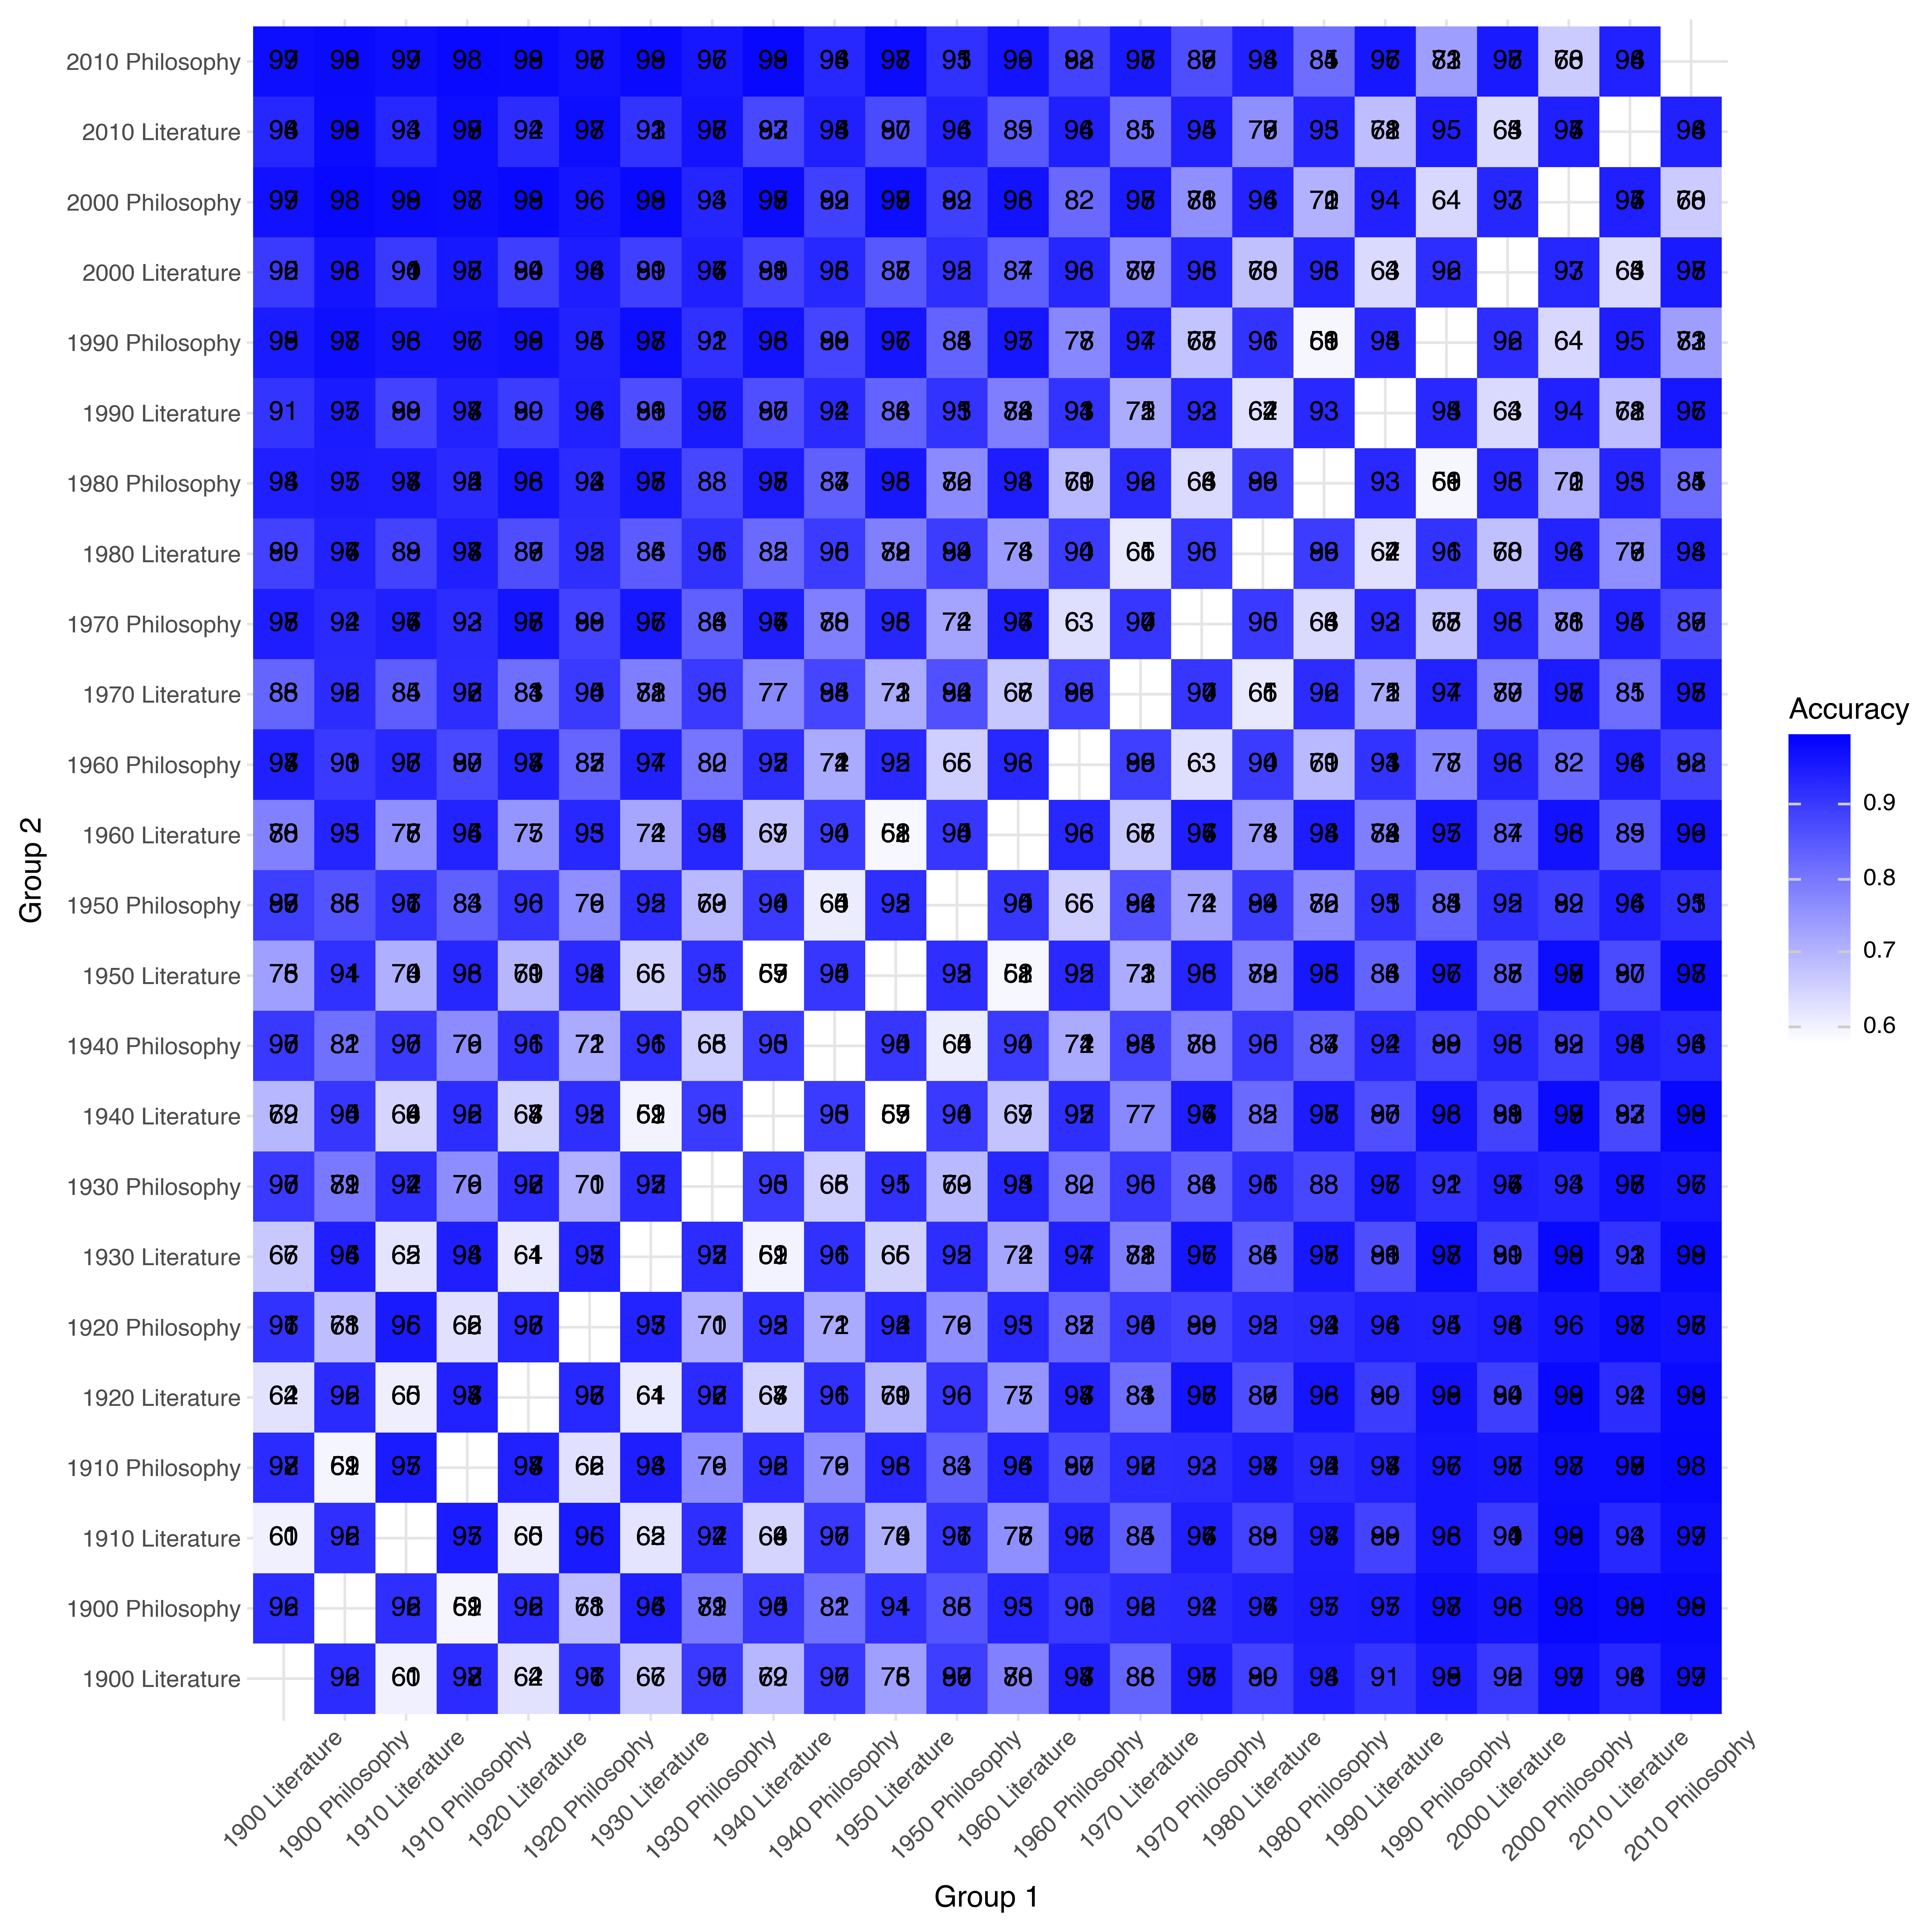

In [ ]:
import plotnine as p9
p9.options.figure_size = (10, 10)
p9.options.dpi = 300

df_preds_sum2 = df_preds_sum.copy()
df_preds_sum2['group1'] = df_preds_sum['group2']
df_preds_sum2['group2'] = df_preds_sum['group1']
df_preds_sum3 = pd.concat([df_preds_sum, df_preds_sum2])

fig = p9.ggplot(df_preds_sum3, p9.aes(x='group1', y='group2', fill='accuracy')) + \
    p9.geom_tile() + \
    p9.geom_text(p9.aes(label='correct_fpk'), color='black', size=10) + \
    p9.scale_fill_gradient(low='white', high='blue') + \
    p9.theme_minimal() + \
    p9.labs(x='Group 1', y='Group 2', fill='Accuracy') + \
    p9.theme(axis_text_x=p9.element_text(angle=45))
fig


In [ ]:
def plot_network(df_preds_sum, wordset, cutoff=.9):

    import networkx as nx
    import matplotlib.pyplot as plt

    G = nx.Graph()
    x = ' / '

    def make_label(period, discipline):
        return f"{period} {discipline}"

    # First, build the graph and collect periods for each node
    node_periods = {}
    node_disciplines = {}

    for i, row in df_preds_sum[df_preds_sum['wordset'] == wordset].set_index('test_label').iterrows():
        a, b = i.split(x)
        a1, a2 = a.split(' ')
        b1, b2 = b.split(' ')
        label_a = make_label(a1, a2)
        label_b = make_label(b1, b2)
        # Store period for node coloring
        node_periods[label_a] = a1
        node_periods[label_b] = b1
        node_disciplines[label_a] = a2
        node_disciplines[label_b] = b2
        if row['accuracy'] >= cutoff:
            continue
        # Store edge, will scale width by accuracy
        G.add_edge(label_a, label_b, weight=row['accuracy'])

    # Create a color map for periods
    periods = sorted({period for period in node_periods.values()})
    disciplines = sorted({discipline for discipline in node_disciplines.values()})
    # color_map = dict(zip(periods, plt.cm.Set1.colors[:len(periods)]))
    color_map = {}
    color_map.update(dict(zip(disciplines, plt.cm.Set2.colors[:len(disciplines)])))

    # Assign colors to nodes based on period
    node_colors = [color_map[node_disciplines[node]] for node in G.nodes()]

    # Prepare edge widths from min to max -> scale to between 1 and 10
    edges = G.edges(data=True)
    edge_weights = [d['weight'] for _, _, d in edges]
    edge_weights_neg = [1-w for w in edge_weights]
    if edge_weights_neg:
        min_w = min(edge_weights_neg)
        max_w = max(edge_weights_neg)
        if max_w > min_w:
            # scale each w from [min_w, max_w] to [1, 10]
            edge_widths = [1 + 9 * ((w - min_w) / (max_w - min_w)) for w in edge_weights_neg]
        else:
            # all weights are the same, use a fixed width
            edge_widths = [5 for _ in edge_weights]
    else:
        edge_widths = []

    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(12, 8))
    nodes = nx.draw_networkx_nodes(G, pos, node_color=node_colors, cmap=plt.cm.Set1)

    nx.draw_networkx_edges(G, pos, edge_color='gray', width=edge_widths)
    nx.draw_networkx_labels(G, pos, font_size=10)

    # Draw edge labels: accuracy to 2 decimal places
    edge_labels = {(u, v): f"{d['weight']:.2f}" for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

    plt.title("Pairwise classification relationships (period as discipline)\n(Node color: period, edge width = accuracy)")
    # Custom legend for periods
    from matplotlib.patches import Patch
    # handles = [Patch(color=color_map[period], label=period) for period in periods]
    handles = [Patch(color=color_map[discipline], label=discipline) for discipline in disciplines]
    plt.legend(handles=handles, title="Period")
    plt.axis("off")
    plt.show()


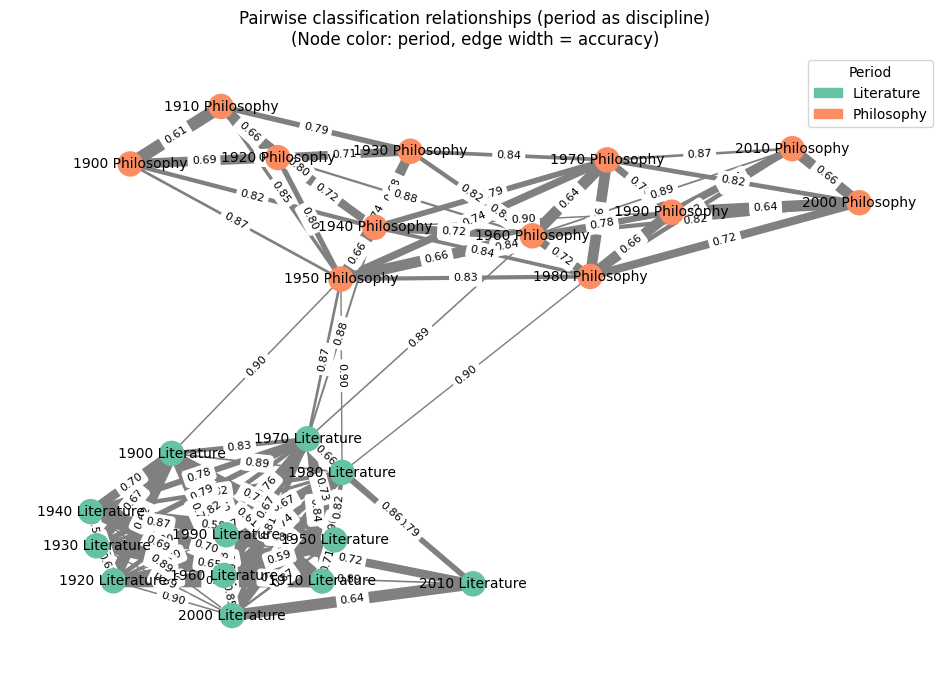

In [ ]:
plot_network(df_preds_sum, 'non_content')

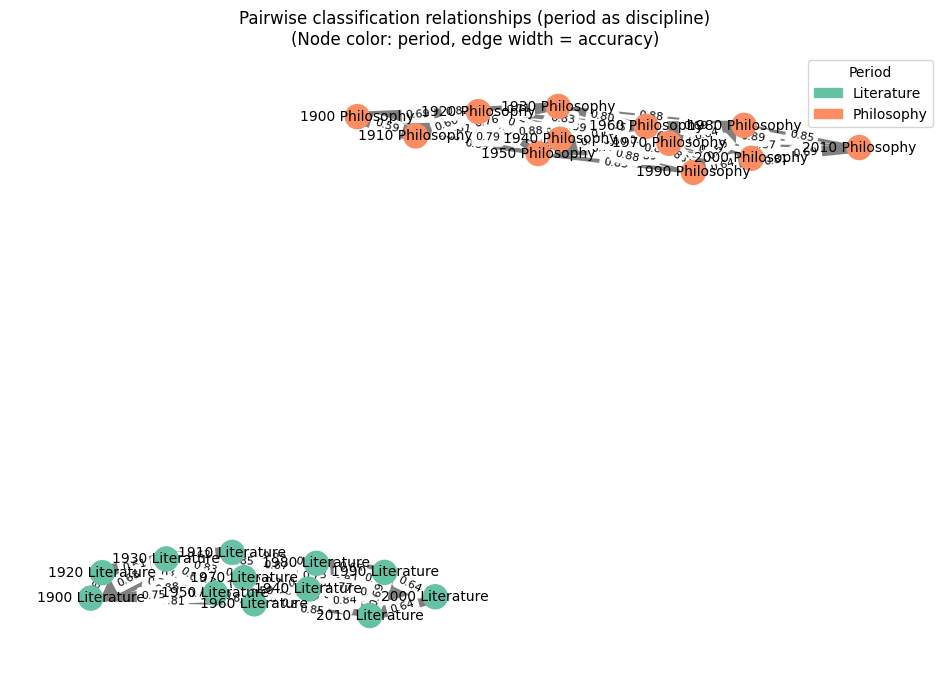

In [ ]:
plot_network(df_preds_sum, 'top')

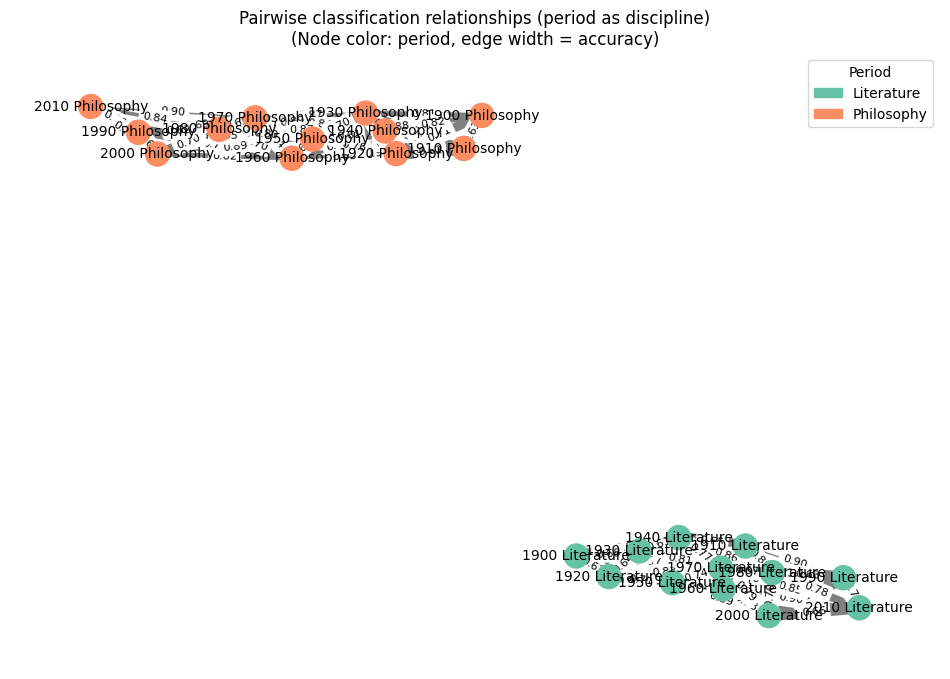

In [ ]:
plot_network(df_preds_sum, 'content')

In [15]:
# # df_preds
# from sklearn.metrics import ConfusionMatrixDisplay
# import matplotlib.pyplot as plt

# fig, ax = plt.subplots(figsize=(10, 10))
# ConfusionMatrixDisplay.from_predictions(df_preds['true_label'], df_preds['pred_label'], ax=ax, xticks_rotation='vertical')
# plt.show()

In [16]:
df_feats

NameError: name 'df_feats' is not defined